#### Домашняя работа

* 1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
---
* 2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
---
* 3. При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

*	общая сумма транзакций по каждой из trx_category
*	общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
*	общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
*	возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.

---

* 4. Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
---
* 5. Дополнительная часть: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Метрика оценки качества - ROC AUC(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
---
* Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
sns.set(rc={'figure.figsize':(12,6)})

In [117]:
raw_df = pd.read_csv('/Users/peter/Desktop/Проблемы качества и очистка данных 2/rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [118]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


### Найдем самые популярные MCC

In [119]:
s = raw_df.groupby(['MCC'])['PERIOD'].count().reset_index().sort_values('PERIOD', ascending = False)

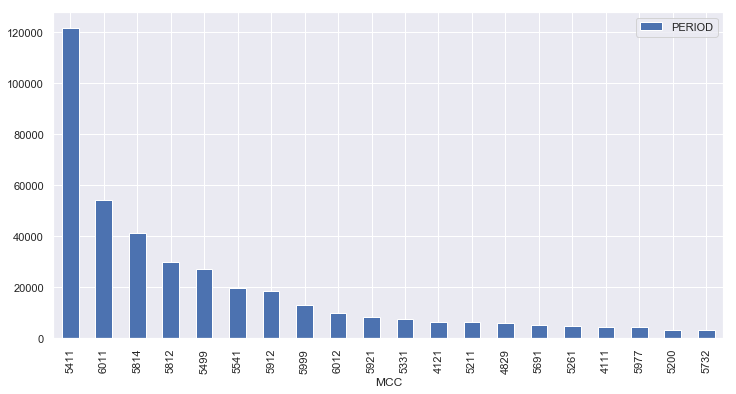

In [120]:
s.head(20).set_index('MCC').plot(kind='bar')

In [121]:
s.head()

,MCC,PERIOD
158,5411,121640
244,6011,54382
198,5814,41351
196,5812,30027
163,5499,27237


In [122]:
#5411 - Супермаркеты
#6011 - Финансовые учреждения – снятие наличности автоматически
#5814 - Фастфуд
#5812 - Общепит
#5499 - Продовольственные магазины

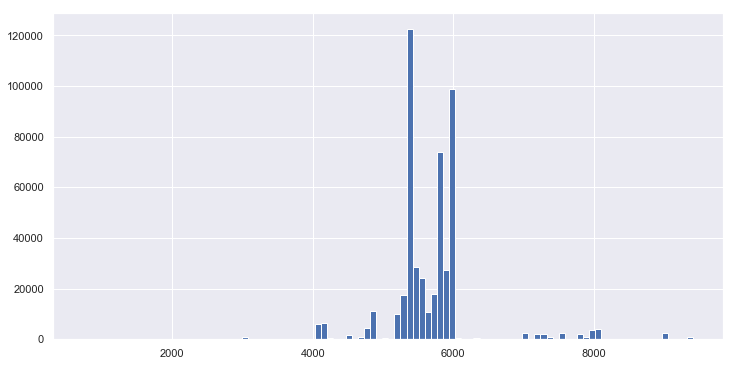

In [123]:
raw_df.MCC.hist(bins=100)

### Самый популярный вид транзакций trx_category

In [124]:
raw_df.groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False)

,trx_category,count_trx
6,POS,416425
5,DEPOSIT,21216
9,WD_ATM_ROS,19104
8,WD_ATM_PARTNER,9948
1,C2C_IN,7306
7,WD_ATM_OTHER,7140
2,C2C_OUT,5456
0,BACK_TRX,2687
4,CAT,1197
3,CASH_ADV,34


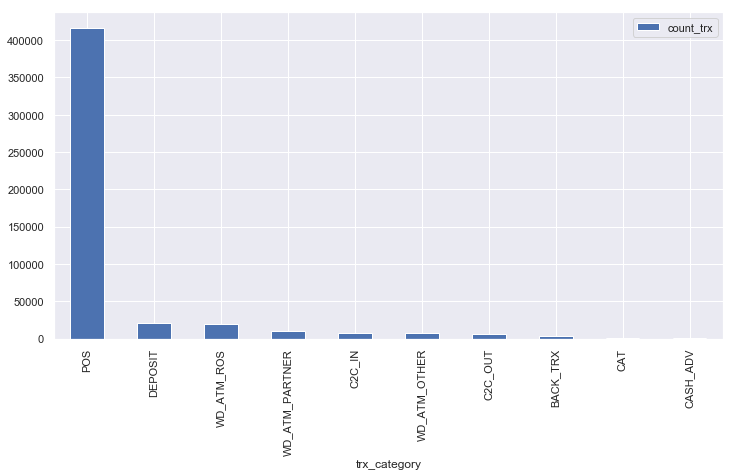

In [125]:
raw_df.groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category').plot(kind='bar')

### Активность по дням недели и времени

In [126]:
experiment_df['hour_of_transaction'] = experiment_df['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H'))

In [127]:
experiment_df.head(20)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,hour_of_transaction,day_of_transaction,type_day
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.00,POS,0,0.0,00,6,1
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.00,DEPOSIT,0,0.0,12,4,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0,00,2,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,0.0,00,6,1
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.00,C2C_OUT,0,0.0,13,2,0
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.00,POS,0,0.0,00,1,0
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.00,POS,0,0.0,00,2,0
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.00,POS,0,0.0,00,1,0
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.00,POS,0,0.0,00,3,0
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.00,POS,0,0.0,00,3,0


### Активность по часам

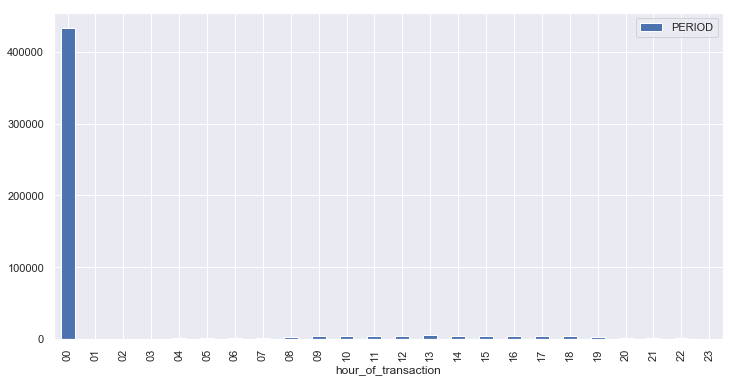

In [128]:
experiment_df.groupby('hour_of_transaction').count().iloc[:,:1].plot(kind='bar')

In [129]:
#Большое количество транзакций проходит в 00 часов, скорее всего это автоматические платежи/подписки/etc.

#Уберем их из графика.

In [130]:
a = experiment_df.groupby(['hour_of_transaction', 'MCC']).count().reset_index().iloc[:,:2]

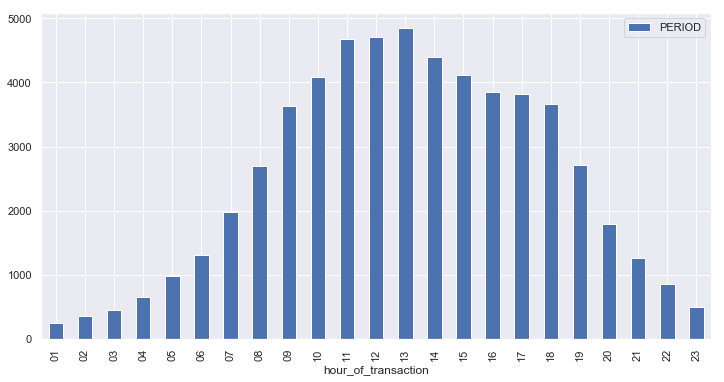

In [131]:
#Получаем почти нормальное распределение
experiment_df.groupby('hour_of_transaction').count().iloc[1:,:1].plot(kind='bar')

### Активность по будням и выходным

In [201]:
experiment_df['day_of_transaction'] = experiment_df['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w'))

In [133]:
experiment_df['type_day'] = experiment_df.day_of_transaction.apply(lambda x: 1 if ((int(x)==6)|(int(x)==0)) else 0)

In [134]:
experiment_df.groupby('type_day').count()['PERIOD']

type_day
0    354372
1    136141
Name: PERIOD, dtype: int64

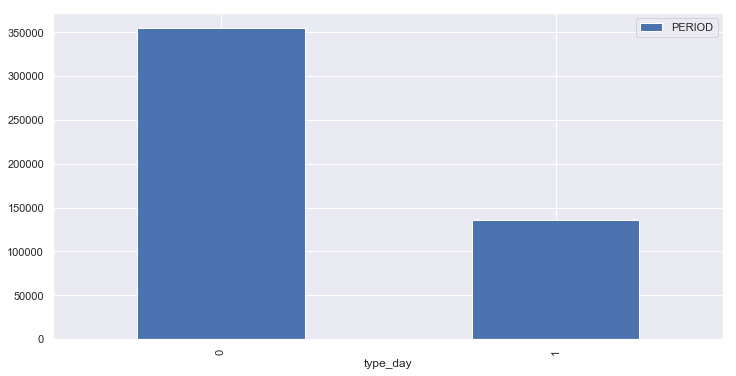

In [135]:
# 1 - выходные, 0 - будни /// добавить сюда средний чек в выходные и будни
experiment_df.groupby('type_day').count().iloc[:,:1].plot(kind='bar')

### Активность по дню недели (вс 0 - сб 7)

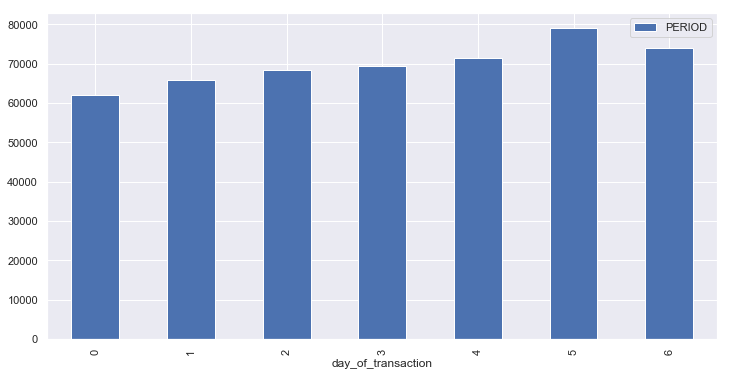

In [136]:
#наибольшее количество операций происходит в пятницу и субботу
experiment_df.groupby('day_of_transaction').count().iloc[:,:1].plot(kind='bar')

In [137]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


#### Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [138]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [139]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  394315
Total transactions in test dataset:  96198


In [140]:
raw_df.channel_type.unique()

array([nan, 'type5', 'type4', 'type2', 'type3', 'type1'], dtype=object)

In [141]:
raw_df.cl_id.unique()

array([    0,     1,     5, ..., 10213, 10214, 10215])

In [142]:
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC'],as_index=False).agg(['sum', 'count']).\
reset_index()

#aggregated_dataset = raw_df_grouped.unstack().fillna(0)
#aggregated_dataset = raw_df_grouped.unstack()

In [143]:
raw_df_grouped.head()

cl_id   MCC   amount      
                   sum count
0     0  5200   5023.0     1
1     0  5411   2031.0     1
2     0  5921    767.0     1
3     0  6011  20000.0     1
4     0  6012  36562.0     1

In [144]:
raw_df_grouped.columns = ['cl_id', 'MCC','amount_sum', 'amount_count']

#### Cохраним сумму покупок по MCC и количество покупок сделанных для конкретного MCC, по каждому cl_id 
* raw_df_grouped

In [145]:
raw_df_grouped.head()

,cl_id,MCC,amount_sum,amount_count
0,0,5200,5023.0,1
1,0,5411,2031.0,1
2,0,5921,767.0,1
3,0,6011,20000.0,1
4,0,6012,36562.0,1


In [146]:
def transaction_by_day_count(dataset):
    #1_добавляем номер дня недели по каждой транзакции в виде отдельной колонки
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    #2_получаем количество транзакций за день для каждого дня недели по каждому клиент_айди
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    
    #3_похоже что проверка, вернуть название колонки из временного датасета ^ , если оно есть в переданном датасете
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    #4_ к названию всех колонок добавляем day_
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    #возвращаем 2_дф, название колонок вида day_N 
    return tmp_df

In [147]:
#для каждого клиент_айди посчитаем количество транзакций по часам
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

#### Создадим новую фичу - количество транзакций по каждой trx_category для каждого клаент_айди
* def trx_category_count

In [158]:
experiment_df.groupby(['cl_id','trx_category'])\
    ['day_of_transaction'].size().unstack().fillna(0).reset_index().head(5)

trx_category,cl_id,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
0,0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,2.0,101.0,0.0,0.0,1.0
2,5,1.0,0.0,8.0,0.0,0.0,4.0,111.0,2.0,2.0,14.0
3,9,0.0,3.0,0.0,0.0,0.0,1.0,29.0,0.0,1.0,5.0
4,10,0.0,1.0,19.0,0.0,3.0,24.0,374.0,0.0,3.0,39.0


In [207]:
#обернем в функцию
def trx_category_count(dataset):
    return dataset.groupby(['cl_id','trx_category'])\
    ['channel_type'].size().unstack().fillna(0).reset_index()

#### Создадим новую фичу - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
* def val_amount

In [160]:
s = raw_df.groupby(['currency']).agg({'amount':'sum'}).reset_index()

In [161]:
s.amount = s.amount.apply(lambda x: int(x))

In [162]:
s.sort_values('amount', ascending = False).head(5)

,currency,amount
44,810,2572996459
37,704,136717976
17,360,71935553
21,410,12609420
19,392,1710582


In [163]:
def val_amount(dataset):
    return dataset.query("currency == 810 | currency == 978 | currency == 840").groupby(['cl_id','currency'])\
    ['amount'].sum().unstack().fillna(0).\
    reset_index().rename(columns={810:'rub_amount',840:'dol_amount',978:'euro_amount'})

In [192]:
val_amount(raw_df).head()

currency,cl_id,rub_amount,dol_amount,euro_amount
0,0,64383.00,0.0,0.00
1,1,266693.13,0.0,884.91
2,5,544874.63,0.0,51.83
3,9,849315.09,0.0,0.00
4,10,1124343.99,0.0,0.00


#### Найдем последнюю транзакцию для каждого client id


In [350]:
df_final = experiment_df.groupby('cl_id', as_index = False).agg({'TRDATETIME':'max'}).\
    rename(columns={'TRDATETIME':'last_timestamp'})

In [331]:
df_final.shape

(5000, 2)

In [332]:
df_final.head()

,cl_id,last_timestamp
0,0,24OCT17:13:14:24
1,1,31JUL17:00:00:00
2,5,31MAR17:00:00:00
3,9,31JUL17:15:51:03
4,10,31JUL17:08:00:37


### Присоединим фичи к final_df

In [351]:
df_final = df_final.merge(val_amount(raw_df), how = 'outer', on = 'cl_id')

In [334]:
df_final.head()

,cl_id,last_timestamp,rub_amount,dol_amount,euro_amount
0,0,24OCT17:13:14:24,64383.00,0.0,0.00
1,1,31JUL17:00:00:00,266693.13,0.0,884.91
2,5,31MAR17:00:00:00,544874.63,0.0,51.83
3,9,31JUL17:15:51:03,849315.09,0.0,0.00
4,10,31JUL17:08:00:37,1124343.99,0.0,0.00


In [335]:
df_final.shape

(5000, 5)

In [215]:
#####

In [352]:
df_final = df_final.merge(transaction_by_day_count(raw_df), how = 'outer', on = 'cl_id')

In [337]:
df_final.head()

,cl_id,last_timestamp,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,24OCT17:13:14:24,64383.00,0.0,0.00,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,31JUL17:00:00:00,266693.13,0.0,884.91,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,31MAR17:00:00:00,544874.63,0.0,51.83,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,31JUL17:15:51:03,849315.09,0.0,0.00,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,31JUL17:08:00:37,1124343.99,0.0,0.00,74.0,35.0,62.0,68.0,65.0,57.0,102.0


In [338]:
df_final.shape

(5000, 12)

In [214]:
#####

In [353]:
df_final = df_final.merge(trx_category_count(raw_df), how = 'outer', on = 'cl_id')

In [340]:
df_final.head()

,cl_id,last_timestamp,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,...,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
0,0,24OCT17:13:14:24,64383.00,0.0,0.00,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
1,1,31JUL17:00:00:00,266693.13,0.0,884.91,7.0,20.0,20.0,16.0,16.0,...,0.0,0.0,0.0,0.0,0.0,2.0,101.0,0.0,0.0,1.0
2,5,31MAR17:00:00:00,544874.63,0.0,51.83,15.0,19.0,19.0,15.0,25.0,...,1.0,0.0,8.0,0.0,0.0,4.0,111.0,2.0,2.0,14.0
3,9,31JUL17:15:51:03,849315.09,0.0,0.00,5.0,8.0,7.0,5.0,6.0,...,0.0,3.0,0.0,0.0,0.0,1.0,29.0,0.0,1.0,5.0
4,10,31JUL17:08:00:37,1124343.99,0.0,0.00,74.0,35.0,62.0,68.0,65.0,...,0.0,1.0,19.0,0.0,3.0,24.0,374.0,0.0,3.0,39.0


In [341]:
df_final.shape

(5000, 22)

In [213]:
#####

In [354]:
df_final = df_final.merge(transaction_by_hour_count(raw_df), how = 'outer', on = 'cl_id')

In [343]:
df_final.head()

,cl_id,last_timestamp,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,...,14,15,16,17,18,19,20,21,22,23
0,0,24OCT17:13:14:24,64383.00,0.0,0.00,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,31JUL17:00:00:00,266693.13,0.0,884.91,7.0,20.0,20.0,16.0,16.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,31MAR17:00:00:00,544874.63,0.0,51.83,15.0,19.0,19.0,15.0,25.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,31JUL17:15:51:03,849315.09,0.0,0.00,5.0,8.0,7.0,5.0,6.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,31JUL17:08:00:37,1124343.99,0.0,0.00,74.0,35.0,62.0,68.0,65.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [344]:
df_final.shape

(5000, 46)

In [219]:
#####

In [ ]:
#тут эксперименты

In [247]:
raw_df['date'] = pd.to_datetime(raw_df['TRDATETIME'], format='%d%b%y:%H:%M:%S')

In [282]:
tmp = raw_df.groupby('cl_id').apply(lambda x: x['date'].max() - x['date'].min()).\
    to_frame().reset_index().\
    rename(columns=({0:'client_life'}))

In [285]:
tmp.head(10)

,cl_id,client_life
0,0,53 days 11:35:53
1,1,92 days 00:00:00
2,5,92 days 00:00:00
3,9,89 days 15:51:03
4,10,89 days 05:14:47
5,11,91 days 00:00:00
6,14,92 days 00:00:00
7,20,73 days 06:33:20
8,21,88 days 00:00:00
9,22,66 days 00:00:00


In [286]:
raw_df = raw_df.merge(tmp, how='outer', on ='cl_id')

In [288]:
raw_df['timestamp'] = raw_df[['date']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)

In [289]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,day_of_transaction,hour_of_transaction,last_timestamp,date,timestamp,client_life
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,6,00,24OCT17:13:14:24,2017-10-21 00:00:00,1508544000,53 days 11:35:53
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,4,12,24OCT17:13:14:24,2017-10-12 12:24:07,1507811047,53 days 11:35:53
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,2,00,24OCT17:13:14:24,2017-12-05 00:00:00,1512432000,53 days 11:35:53
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,6,00,24OCT17:13:14:24,2017-10-21 00:00:00,1508544000,53 days 11:35:53
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2,13,24OCT17:13:14:24,2017-10-24 13:14:24,1508850864,53 days 11:35:53


In [295]:
users_data = raw_df.groupby('cl_id', as_index = False).\
                agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [318]:
users_data_2 = raw_df.groupby('cl_id', as_index = False).\
                agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'})

In [297]:
raw_df = raw_df.merge(users_data, how='outer', on='cl_id')

In [319]:
raw_df = raw_df.merge(users_data_2, how='outer', on='cl_id')

In [320]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,day_of_transaction,hour_of_transaction,last_timestamp_x,date,timestamp,client_life,last_timestamp_y,min_timestamp
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,6,00,24OCT17:13:14:24,2017-10-21 00:00:00,1508544000,53 days 11:35:53,1512432000,1507811047
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,4,12,24OCT17:13:14:24,2017-10-12 12:24:07,1507811047,53 days 11:35:53,1512432000,1507811047
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,2,00,24OCT17:13:14:24,2017-12-05 00:00:00,1512432000,53 days 11:35:53,1512432000,1507811047
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,6,00,24OCT17:13:14:24,2017-10-21 00:00:00,1508544000,53 days 11:35:53,1512432000,1507811047
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2,13,24OCT17:13:14:24,2017-10-24 13:14:24,1508850864,53 days 11:35:53,1512432000,1507811047


In [325]:
raw_df['client_life'] = raw_df['client_life'].apply(lambda x: str(x).split(' ')[0])

In [326]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,day_of_transaction,hour_of_transaction,last_timestamp_x,date,timestamp,client_life,last_timestamp_y,min_timestamp
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,6,00,24OCT17:13:14:24,2017-10-21 00:00:00,1508544000,53,1512432000,1507811047
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,4,12,24OCT17:13:14:24,2017-10-12 12:24:07,1507811047,53,1512432000,1507811047
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,2,00,24OCT17:13:14:24,2017-12-05 00:00:00,1512432000,53,1512432000,1507811047
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,6,00,24OCT17:13:14:24,2017-10-21 00:00:00,1508544000,53,1512432000,1507811047
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2,13,24OCT17:13:14:24,2017-10-24 13:14:24,1508850864,53,1512432000,1507811047


### Добавим количество операций для каждого client id c за последние 14 дней

In [355]:
df_final = df_final.merge(raw_df.query("timestamp >= last_timestamp_y - 14 * 24 * 60* 60").\
    groupby('cl_id').count().\
    reset_index().iloc[:,:2].\
    rename(columns={'PERIOD':'count_tran_14days'}), how='outer')

In [356]:
df_final.shape

(5000, 47)

### Добавим количество операций для каждого client id за 28 дней до последней операции - последние 14 дней

In [358]:
df_final = df_final.merge(raw_df.query("(timestamp >= last_timestamp_y - 28 * 24 * 60* 60) & (timestamp <=last_timestamp_y - 14 * 24 * 60* 60) ").\
    groupby('cl_id').count().\
    reset_index().iloc[:,:2].\
    rename(columns={'PERIOD':'count_tran_28days'}), how='outer')

In [364]:
df_final.shape

(5000, 48)

### Добавим количество операций для каждого client id за 7 дней до последней операции

In [366]:
df_final = df_final.merge(raw_df.query("timestamp >= last_timestamp_y - 7 * 24 * 60* 60").\
    groupby('cl_id').count().\
    reset_index().iloc[:,:2].\
    rename(columns={'PERIOD':'count_tran_7days'}), how='outer')

In [368]:
df_final.head()

,cl_id,last_timestamp,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,...,17,18,19,20,21,22,23,count_tran_14days,count_tran_28days,count_tran_7days
0,0,24OCT17:13:14:24,64383.00,0.0,0.00,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,1
1,1,31JUL17:00:00:00,266693.13,0.0,884.91,7.0,20.0,20.0,16.0,16.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,15,44.0,8
2,5,31MAR17:00:00:00,544874.63,0.0,51.83,15.0,19.0,19.0,15.0,25.0,...,4.0,5.0,2.0,0.0,0.0,0.0,0.0,30,12.0,19
3,9,31JUL17:15:51:03,849315.09,0.0,0.00,5.0,8.0,7.0,5.0,6.0,...,1.0,2.0,0.0,1.0,1.0,0.0,3.0,7,9.0,3
4,10,31JUL17:08:00:37,1124343.99,0.0,0.00,74.0,35.0,62.0,68.0,65.0,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,53,70.0,22


In [369]:
df_final.corr()

,cl_id,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,day_5,...,17,18,19,20,21,22,23,count_tran_14days,count_tran_28days,count_tran_7days
cl_id,1.000000,-0.040170,-0.000099,-0.016727,-0.117233,-0.117860,-0.106346,-0.107238,-0.118272,-0.139680,...,-0.012277,-0.004681,0.004296,-0.017709,0.013805,-0.005117,-0.002403,-0.137290,-0.085204,-0.133594
rub_amount,-0.040170,1.000000,-0.026433,-0.002279,0.136012,0.200635,0.190427,0.208346,0.196538,0.181087,...,0.269341,0.230544,0.194135,0.161507,0.164277,0.105081,0.096050,0.140182,0.104341,0.136306
dol_amount,-0.000099,-0.026433,1.000000,0.006575,-0.008810,-0.004788,-0.002032,0.000830,0.005821,-0.004717,...,-0.015202,-0.016866,-0.016144,-0.011758,-0.012753,-0.004236,-0.010301,-0.004511,0.005164,0.007814
euro_amount,-0.016727,-0.002279,0.006575,1.000000,0.001279,-0.001136,-0.002736,-0.001070,0.000713,-0.007968,...,-0.022276,-0.011224,-0.016635,-0.004776,-0.015582,-0.015233,0.007263,0.009040,-0.004161,0.019233
day_0,-0.117233,0.136012,-0.008810,0.001279,1.000000,0.708975,0.710397,0.700049,0.710800,0.716801,...,0.176332,0.188304,0.197383,0.161145,0.191061,0.158442,0.135234,0.658024,0.674433,0.558516
day_1,-0.117860,0.200635,-0.004788,-0.001136,0.708975,1.000000,0.828203,0.817802,0.817728,0.807735,...,0.209634,0.209730,0.195605,0.177163,0.184765,0.148116,0.124505,0.695243,0.716822,0.597148
day_2,-0.106346,0.190427,-0.002032,-0.002736,0.710397,0.828203,1.000000,0.836680,0.830334,0.809173,...,0.207333,0.202202,0.188045,0.175707,0.168195,0.128574,0.124823,0.698963,0.728454,0.600236
day_3,-0.107238,0.208346,0.000830,-0.001070,0.700049,0.817802,0.836680,1.000000,0.829654,0.819361,...,0.224086,0.211845,0.201928,0.174444,0.185926,0.138813,0.123128,0.701082,0.714364,0.595879
day_4,-0.118272,0.196538,0.005821,0.000713,0.710800,0.817728,0.830334,0.829654,1.000000,0.830089,...,0.207857,0.198744,0.195145,0.181713,0.166159,0.142233,0.127556,0.713503,0.735441,0.606178
day_5,-0.139680,0.181087,-0.004717,-0.007968,0.716801,0.807735,0.809173,0.819361,0.830089,1.000000,...,0.220756,0.200502,0.200733,0.169125,0.165018,0.118830,0.114186,0.711973,0.721037,0.602372


In [370]:
df_final = df_final.drop('last_timestamp', axis = 1)

In [371]:
df_final.head()

,cl_id,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,day_5,...,17,18,19,20,21,22,23,count_tran_14days,count_tran_28days,count_tran_7days
0,0,64383.00,0.0,0.00,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,1
1,1,266693.13,0.0,884.91,7.0,20.0,20.0,16.0,16.0,10.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,15,44.0,8
2,5,544874.63,0.0,51.83,15.0,19.0,19.0,15.0,25.0,24.0,...,4.0,5.0,2.0,0.0,0.0,0.0,0.0,30,12.0,19
3,9,849315.09,0.0,0.00,5.0,8.0,7.0,5.0,6.0,4.0,...,1.0,2.0,0.0,1.0,1.0,0.0,3.0,7,9.0,3
4,10,1124343.99,0.0,0.00,74.0,35.0,62.0,68.0,65.0,57.0,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,53,70.0,22


In [387]:
df_final = df_final.merge(raw_df.groupby('cl_id').target_flag.unique().\
                              apply(lambda x: x[0]).to_frame().reset_index(), how='outer', on='cl_id')

In [392]:
df_final.head()

,cl_id,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,day_5,...,18,19,20,21,22,23,count_tran_14days,count_tran_28days,count_tran_7days,target_flag
0,0,64383.00,0.0,0.00,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0
1,1,266693.13,0.0,884.91,7.0,20.0,20.0,16.0,16.0,10.0,...,0.0,2.0,1.0,0.0,0.0,0.0,15,44.0,8,0
2,5,544874.63,0.0,51.83,15.0,19.0,19.0,15.0,25.0,24.0,...,5.0,2.0,0.0,0.0,0.0,0.0,30,12.0,19,1
3,9,849315.09,0.0,0.00,5.0,8.0,7.0,5.0,6.0,4.0,...,2.0,0.0,1.0,1.0,0.0,3.0,7,9.0,3,0
4,10,1124343.99,0.0,0.00,74.0,35.0,62.0,68.0,65.0,57.0,...,0.0,0.0,1.0,0.0,0.0,0.0,53,70.0,22,0


In [389]:
df_final.isnull().sum()

cl_id                  0
rub_amount             1
dol_amount             1
euro_amount            1
day_0                  0
day_1                  0
day_2                  0
day_3                  0
day_4                  0
day_5                  0
day_6                  0
BACK_TRX               0
C2C_IN                 0
C2C_OUT                0
CASH_ADV               0
CAT                    0
DEPOSIT                0
POS                    0
WD_ATM_OTHER           0
WD_ATM_PARTNER         0
WD_ATM_ROS             0
00                     0
01                     0
02                     0
03                     0
04                     0
05                     0
06                     0
07                     0
08                     0
09                     0
10                     0
11                     0
12                     0
13                     0
14                     0
15                     0
16                     0
17                     0
18                     0


In [390]:
df_final = df_final.fillna(0)

cl_id                0
rub_amount           0
dol_amount           0
euro_amount          0
day_0                0
day_1                0
day_2                0
day_3                0
day_4                0
day_5                0
day_6                0
BACK_TRX             0
C2C_IN               0
C2C_OUT              0
CASH_ADV             0
CAT                  0
DEPOSIT              0
POS                  0
WD_ATM_OTHER         0
WD_ATM_PARTNER       0
WD_ATM_ROS           0
00                   0
01                   0
02                   0
03                   0
04                   0
05                   0
06                   0
07                   0
08                   0
09                   0
10                   0
11                   0
12                   0
13                   0
14                   0
15                   0
16                   0
17                   0
18                   0
19                   0
20                   0
21                   0
22         

In [396]:
y = df_final.target_flag

In [398]:
X = df_final.iloc[:,:-1]

In [400]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [404]:
dt = DecisionTreeClassifier()

In [405]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [406]:
parameters = {'max_depth':range(1,10),'min_samples_split':range(2,11), 'min_samples_leaf':range(1,11)}

In [407]:
search = RandomizedSearchCV(dt, parameters, cv=5)

In [408]:
search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': range(1, 10), 'min_samples_split': range(2, 11), 'min_samples_leaf': range(1, 11)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [409]:
best_tree = search.best_estimator_ 

In [410]:
best_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

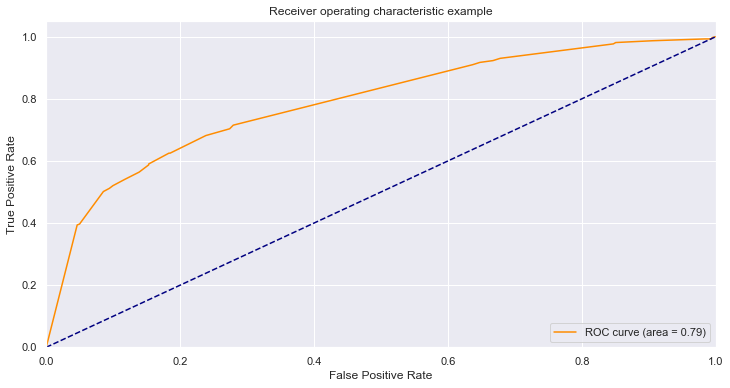

In [416]:
#Построим roc-auc

#сохраним вероятности в отдельную переменную
y_predicted_prob = best_tree.predict_proba(X_test)

#график
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()